## Inital Setup

Run the following script to extract all data from subfolders

`find . -mindepth 2 -type f -print -exec mv {} . \;`

Delete all empty folders from dataset dir

`find -mindepth 1 -maxdepth 1 -type d -exec rm -r {} \;`

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
from typing import List, Dict, Tuple
from itables import init_notebook_mode
from sklearn import manifold, datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from matplotlib import ticker


In [3]:
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [4]:
dataset_dir = "../Dataset"

## Dataset attributes

- **site_id** - ID code for the source hospital.
- **patient_id** - ID code for the patient.
- **image_id** - ID code for the image.
- **laterality** - Whether the image is of the left or right breast.
- **view** - The orientation of the image. The default for a screening exam is to capture two views per breast.
- **age** - The patient's age in years.
- **implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- **density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- **machine_id** - An ID code for the imaging device.
- **cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- **biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- **invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- **BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- **prediction_id** - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
- **difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

In [5]:
train_dataset = pd.read_csv('../train.csv')
test_dataset = pd.read_csv('../test.csv')

In [6]:
train_dataset

site_id  patient_id    image_id laterality view   age  cancer  biopsy   
0            2       10006   462822612          L   CC  61.0       0       0  \
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
43739        1        9973  1729524723          R  MLO  43.0       0       0   
43740        1        9989    63473691          L  MLO  60.0       0       0   
43741        1        9989  1078943060          L   CC  60.0       0       0   
43742        1        9989   398038886          R  MLO  60.0       0       0   
43743        1        9989   439796429          R   CC  60.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0             0     NaN        0     NaN          29                    False  
1             0     NaN        0     NaN          29                    False  
2             0     NaN        0     NaN          29                    False  
3             0     NaN        0     NaN          29                    False  
4             0     0.0        0     NaN          21                     True  
...         ...     ...      ...     ...         ...                      ...  
43739         0     1.0        0       C          49                    False  
43740         0     NaN        0       C         216                    False  
43741         0     NaN        0       C         216                    False  
43742         0     0.0        0       C         216                     True  
43743         0     0.0        0       C         216                     True  

[43744 rows x 14 columns]

In [7]:
train_neg_samples_cnt, train_pos_samples_cnt = train_dataset['cancer'].value_counts()
test_neg_samples_cnt, test_pos_samples_cnt = test_dataset['cancer'].value_counts()

print(f"Train dataset: {train_neg_samples_cnt} negative samples and {train_pos_samples_cnt} positive samples")
print(f"Test dataset: {test_neg_samples_cnt} negative samples and {test_pos_samples_cnt} positive samples")

Train dataset: 42778 negative samples and 966 positive samples
Test dataset: 10770 negative samples and 192 positive samples


In [8]:
def process_columns_names(columns: List[str]) -> List[str]:
    new_cols=[]
    for column in columns:
        if len(column.split('onehotencoder__')) > 1:
            new_cols.append(column.split('onehotencoder__')[1])
        elif len(column.split('remainder__')) > 1:
            new_cols.append(column.split('remainder__')[1])
    return new_cols

train_dataset = train_dataset.fillna(train_dataset.mode().iloc[0])

# one hot encode categorical data
encoder = OneHotEncoder(drop='if_binary')

columns_to_one_hot = ['view','laterality', 'density']

transformer = make_column_transformer(
    (encoder, columns_to_one_hot),
    remainder='passthrough')

transformed = transformer.fit_transform(train_dataset)
encoded_train_df = pd.DataFrame(
    transformed, 
    columns=process_columns_names(transformer.get_feature_names_out())
)


# clean dataset by removing meaningless columns for visualization
encoded_train_df = encoded_train_df.drop(columns=['site_id', 'patient_id', 'image_id', "machine_id"])

encoded_train_df

view_AT view_CC view_LM view_LMO view_ML view_MLO laterality_R   
0         0.0     1.0     0.0      0.0     0.0      0.0          0.0  \
1         0.0     0.0     0.0      0.0     0.0      1.0          0.0   
2         0.0     0.0     0.0      0.0     0.0      1.0          1.0   
3         0.0     1.0     0.0      0.0     0.0      0.0          1.0   
4         0.0     1.0     0.0      0.0     0.0      0.0          0.0   
...       ...     ...     ...      ...     ...      ...          ...   
43739     0.0     0.0     0.0      0.0     0.0      1.0          1.0   
43740     0.0     0.0     0.0      0.0     0.0      1.0          0.0   
43741     0.0     1.0     0.0      0.0     0.0      0.0          0.0   
43742     0.0     0.0     0.0      0.0     0.0      1.0          1.0   
43743     0.0     1.0     0.0      0.0     0.0      0.0          1.0   

      density_A density_B density_C density_D   age cancer biopsy invasive   
0           0.0       1.0       0.0       0.0  61.0      0      0        0  \
1           0.0       1.0       0.0       0.0  61.0      0      0        0   
2           0.0       1.0       0.0       0.0  61.0      0      0        0   
3           0.0       1.0       0.0       0.0  61.0      0      0        0   
4           0.0       1.0       0.0       0.0  55.0      0      0        0   
...         ...       ...       ...       ...   ...    ...    ...      ...   
43739       0.0       0.0       1.0       0.0  43.0      0      0        0   
43740       0.0       0.0       1.0       0.0  60.0      0      0        0   
43741       0.0       0.0       1.0       0.0  60.0      0      0        0   
43742       0.0       0.0       1.0       0.0  60.0      0      0        0   
43743       0.0       0.0       1.0       0.0  60.0      0      0        0   

      BIRADS implant difficult_negative_case  
0        1.0       0                   False  
1        1.0       0                   False  
2        1.0       0                   False  
3        1.0       0                   False  
4        0.0       0                    True  
...      ...     ...                     ...  
43739    1.0       0                   False  
43740    1.0       0                   False  
43741    1.0       0                   False  
43742    0.0       0                    True  
43743    0.0       0                    True  

[43744 rows x 18 columns]

In [9]:
## Data visualization
t_sne = manifold.TSNE(
    n_components=3,
    perplexity=15,
    init="random",
    n_iter=500,
    random_state=0,
)
tsne_data = t_sne.fit_transform(encoded_train_df)

tsne_data.shape


(43744, 3)

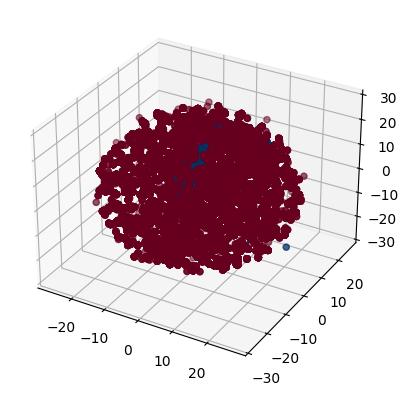

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne_data), c=train_dataset['cancer'], cmap='RdBu')
plt.show()

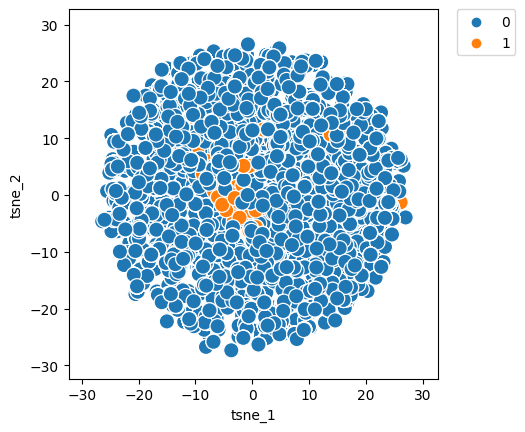

In [11]:

# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_data[:,0], 'tsne_2': tsne_data[:,1], 'label': train_dataset['cancer']})
fig, ax = plt.subplots(1)
sn.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
lim = (tsne_data.min()-5, tsne_data.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)